In [2]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteractiveGraph # pip install netgraph

import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
from itertools import product, permutations
mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool
def nthRootsOfUnity(n): # constant space, serial
    from cmath import exp, pi
    c = 2j * pi / n
    return [exp(k * c) for k in range(n)]

In [25]:
def boolean_phase_oracles(problem):
    n = problem.n
    oracles = {}
    for instance in problem.instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] = (-1)**instance[i]
        oracles[instance] = oracle
    return oracles
    
def unitary_relax_opt(problem, workspace_bits, t):
    n = problem.n
    workspace_size = 2**workspace_bits
    size = n * workspace_size
    oracles = boolean_phase_oracles(problem)
    oracles = {instance: np.kron(oracles[instance], np.ones((workspace_size, workspace_size))) for instance in oracles}
    no_vect = np.eye(1, size, 0).T
    yes_vect = np.eye(1, size, 1).T
    # print(no_vect)
    # print(yes_vect)
    C = cp.Variable((size, size), complex=True)
    constraints = [cp.norm(C,2)<=1]
    root = nthRootsOfUnity(t)[-1]
    print('root', root, root**t)
    eps = cp.Variable(nonneg=True)
    for instance in problem.no_instances:
        constraints += [oracles[instance] @ C @ no_vect == root * no_vect]
    
    for instance in problem.yes_instances:
        constraints += [oracles[instance] @ C @ yes_vect == root * yes_vect]
    
    opt_prob = cp.Problem(cp.Minimize(eps), constraints)
    opt_prob.solve(solver='MOSEK', verbose=True)
    return C.value

def branching_moment_sdp(problem, size, length):
    n = problem.n
    num_nodes = n*size
    oracles = boolean_phase_oracles(problem)
    oracles = {instance: np.kron(oracles[instance], np.ones((workspace_size, workspace_size))) for instance in oracles}
    combo_dict = [list(itertools.combinations(range(num_nodes, i))) for i in range(length)]
    index_to_combo = []
    for i in range(len(combo_dict)):
        index_to_combo += combo_dict[i]
    combo_to_index = {index_to_combo[i]: i for i in range(len(index_to_combo))}
    moment_size = sum(len(combo) for _, combo in combo_dict.items()) 
    moments = cp.Variable((moment_size, moment_size), PSD=True)

def flow_sdp(problem, size, length):
    oracles = boolean_phase_oracles(problem)
    # oracles = {instance: np.kron(oracles[instance], np.ones((workspace_size, workspace_size))) for instance in oracles}
    flows = cp.Variable((n, size, n, size))
    constraints = []

    # total flow
    for j in range(length):
        constraints += [cp.norm(flows[:, :, j], 'fro') <= 1]

    
n=2
prob = threshold_k(n, 1)
C = unitary_relax_opt(prob, 2, 7)
        
    
    

root (0.6234898018587334-0.7818314824680299j) (0.9999999999999999-1.27675647831893e-15j)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 06 06:09:02 PM: Your problem has 65 variables, 25 constraints, and 0 parameters.
(CVXPY) Aug 06 06:09:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 06:09:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 06:09:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 06 06:09:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
--------------------------------------------------------------

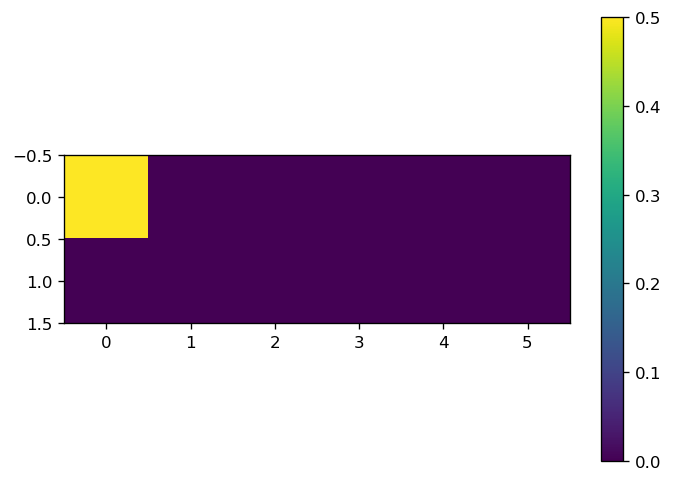

In [20]:
visualize(C, complex=True)